<a href="https://colab.research.google.com/github/Warunee2465/Fitness-social-analytics/blob/main/Social_fitness_insights_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **1. Data Analysis and Presentation Preparation**


---



### **Topic: Social Fitness Insights**

---
- We combine a rule-based tag engine with NMF/LDA topic modeling because rules give business reliable categories, while topics discover hidden themes together they’re accurate and exploratory for better decisions.





---

### **Method summary.**

---

- We first clean and standardize the social posts, then apply a rule-based tag engine to map each post into our 8 business categories (e.g., Workout, Facilities, Service) because it’s deterministic, explainable, and aligns to owner goals.

- In parallel, we run NMF/LDA topic modeling because it reveals organic clusters and emerging themes we didn’t predefine.
- We compare both to validate categories, quantify coverage/agreement, and surface insights that translate into campaign and ops actions.


## 🌴 **Step 1: Data Preparation and Cleaning (Question 1.4 & Key Responsibility)**


---
---

Data prep and  cleaning standardize columns, remove duplicates, normalize text, parse dates, and safely handle missing engagement because reliable features prevent biased tagging and unstable topics.



## **#0. Set up library and Import data**


---



In [ ]:
!pip install pythainlp

In [ ]:
!apt-get install fonts-thai-tlwg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-thai-tlwg is already the newest version (1:0.7.3-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
!pip install -q pythainlp scikit-learn pyLDAvis

In [ ]:
# Core
import os
import re
import unicodedata
from itertools import islice
from dataclasses import dataclass, field
from typing import List, Pattern, Dict

# Data & Progress
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP (Thai language processing)
from pythainlp import word_tokenize
from pythainlp.corpus.common import thai_stopwords

# Machine Learning / Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Load the Excel file
file_path = "/content/Test_Data_Analyst__-_Spacebar.xlsx"
# Read only the "Data" sheet
social_df = pd.read_excel(file_path, sheet_name="Data")

# Save cleaned version (only data sheet)
social_df.to_csv("fitness_data_clean.csv", index=False)

# Display the column names and their data types
social_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         4382 non-null   int64  
 1   Title                      4382 non-null   object 
 2   Detail                     4382 non-null   object 
 3   Link                       4382 non-null   object 
 4   Source                     4382 non-null   object 
 5   Update date                4382 non-null   object 
 6   Publish date               4382 non-null   object 
 7   Sentiment                  4382 non-null   object 
 8   Ranking                    4382 non-null   int64  
 9   Media type                 4382 non-null   object 
 10  Tags                       0 non-null      float64
 11  Country                    1803 non-null   object 
 12  Language                   4382 non-null   object 
 13  Audience                   4382 non-null   int64

## **1) Understand the Data and analysis (EDA)**

---



### **a. Basic exploration**

In [ ]:
# 1. Head / Tails

display(social_df.head())
display(social_df.tail())

,id,Title,Detail,Link,Source,Update date,Publish date,Sentiment,Ranking,Media type,...,Reach,Interactions,Notes,Author name,Author handle (@username),Author URL,Gender,Age,Bio,City
0,852313,RT @beam_taiyo: “ตัดกระเพาะให้สุขภาพดีขึ้น ดูด...,RT @beam_taiyo: “ตัดกระเพาะให้สุขภาพดีขึ้น ดูด...,https://twitter.com/FishiBumiemook/status/1755...,twitter.com,07/02/2024 16:17:25,07/02/2024 16:16:48,Neutral,3,twitter,...,9,0.0,NaN,จัดจ้านในย่านนี้ ft.เด่กปากแจ๋ว,FishiBumiemook,https://twitter.com/FishiBumiemook,Male,NaN,ชาติ คิเฮ ป๋อจ้าน เงินทั้งหมดนี้ให้เอสเจและเซี...,Seoul
1,852315,RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ...,RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ...,https://twitter.com/AonnuanSukanya/status/1755...,twitter.com,07/02/2024 16:17:40,07/02/2024 16:17:05,Negative,1,twitter,...,1,0.0,NaN,พุเพว,AonnuanSukanya,https://twitter.com/AonnuanSukanya,Female,NaN,NaN,NaN
2,852317,RT @2Ltloving: สูง 180 หนัก 65 ชอบม้าๆ\n\nเอ็น...,RT @2Ltloving: สูง 180 หนัก 65 ชอบม้าๆ\n\nเอ็น...,https://twitter.com/PSrimaneechai/status/17551...,twitter.com,07/02/2024 16:18:10,07/02/2024 16:17:39,Positive,1,twitter,...,1,0.0,NaN,pair Srimaneechai,PSrimaneechai,https://twitter.com/PSrimaneechai,Male,NaN,NaN,NaN
3,852319,RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ...,RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ...,https://twitter.com/Ziq36056304/status/1755159...,twitter.com,07/02/2024 16:19:11,07/02/2024 16:18:39,Negative,1,twitter,...,1,0.0,NaN,:snowflake:Paint_Me_Naked,Ziq36056304,https://twitter.com/Ziq36056304,Female,NaN,NaN,NaN
4,852323,RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ...,RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ...,https://twitter.com/ppnchilli/status/175515943...,twitter.com,07/02/2024 16:20:25,07/02/2024 16:19:53,Negative,1,twitter,...,1,0.0,NaN,พพ แอนด์ ชล,ppnchilli,https://twitter.com/ppnchilli,Male,NaN,#BTS #BTSARMY :purple_heart: #CNBLUE :blue_hea...,NaN


,id,Title,Detail,Link,Source,Update date,Publish date,Sentiment,Ranking,Media type,...,Reach,Interactions,Notes,Author name,Author handle (@username),Author URL,Gender,Age,Bio,City
4377,819287,การออกกำลังกาย นอกจาก emi wong แนะนำ shirlyn k...,การออกกำลังกาย นอกจาก emi wong แนะนำ shirlyn k...,https://twitter.com/shareshare_km/status/17490...,twitter.com,05/02/2024 17:38:27,21/01/2024 17:02:52,Negative,1,twitter,...,1,2.0,NaN,Shareshare.kormor,shareshare_km,https://twitter.com/shareshare_km,Male,NaN,แชร์ทุกสิ่งทุกอย่างที่ใช้แล้วดี หรือลองทำแล้วด...,NaN
4378,841737,ปีใหม่นี้สัญญากับตัวเองว่าจะเริ่มออกกำลังกาย ...,ปีใหม่นี้สัญญากับตัวเองว่าจะเริ่มออกกำลังกาย ...,https://twitter.com/meowhrinn/status/174254384...,twitter.com,06/02/2024 22:23:41,03/01/2024 20:50:03,Neutral,1,twitter,...,1,10.0,NaN,wanshi,meowhrinn,https://twitter.com/meowhrinn,Female,NaN,มีหมาอ้วนเป็นของตัวเองรึยางง :sparkles:,Bangkok
4379,841995,สายออกกำลังกายต้องลองน้าา แนะนำจริงง Dietor Gu...,สายออกกำลังกายต้องลองน้าา แนะนำจริงง Dietor Gu...,https://twitter.com/harybool/status/1735997599...,twitter.com,06/02/2024 23:55:56,16/12/2023 19:17:35,Neutral,7,twitter,...,251,6.0,NaN,อาหลีว่าดีย์,harybool,https://twitter.com/harybool,Female,NaN,ทาสรั่ก biscoff #DM & #LINE For Work ₊⋆യ ₊⋆ :p...,Líně
4380,847769,"ทัวร์เพื่อคน "" ภาวะ สมองเสื่อม "" รับอนาคต ""ผู้...",การท่องเที่ยว “แนวใหม่” เพื่อคน “ภาวะ สมองเสื่...,https://ngthai.com/travel/53460/dementia-tourism,ngthai.com,07/02/2024 11:06:55,15/01/2024 13:16:27,Neutral,5,news,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4381,882413,โปรโมชั่น พิเศษปี2567:handshake::fire:\n#ที่ยิ...,โปรโมชั่น พิเศษปี2567:handshake::fire:\n#ที่ยิ...,https://twitter.com/BreeseLA/status/1743850525...,twitter.com,08/02/2024 14:00:25,07/01/2024 11:22:19,Positive,9,twitter,...,2332,87.0,NaN,ทหารสายกล้าม,BreeseLA,https://twitter.com/BreeseLA,Female,NaN,ทหารบ้านนอกที่ชอบออกกำลังกาย\nขายสินค้าใช้แล้ว...,NaN


In [ ]:
# 2. Shape and dtypes

print("Shape", social_df.shape)

Shape (4382, 24)


In [ ]:
social_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         4382 non-null   int64  
 1   Title                      4382 non-null   object 
 2   Detail                     4382 non-null   object 
 3   Link                       4382 non-null   object 
 4   Source                     4382 non-null   object 
 5   Update date                4382 non-null   object 
 6   Publish date               4382 non-null   object 
 7   Sentiment                  4382 non-null   object 
 8   Ranking                    4382 non-null   int64  
 9   Media type                 4382 non-null   object 
 10  Tags                       0 non-null      float64
 11  Country                    1803 non-null   object 
 12  Language                   4382 non-null   object 
 13  Audience                   4382 non-null   int64

In [ ]:
# 3. Summary statistics and Transpose for readability

social_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4382.0,708133.479690,9.831250e+04,397221.0,612985.5,676896.0,804766.50,882965.0
Ranking,4382.0,3.207668,2.713810e+00,1.0,1.0,2.0,6.00,10.0
Tags,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Audience,4382.0,92160.720219,1.723223e+06,0.0,29.0,150.5,4164.75,96787989.0
Reach,4382.0,3617.007531,7.377112e+04,1.0,1.0,4.0,52.00,4161883.0
Interactions,4183.0,36.528568,5.034474e+02,0.0,0.0,0.0,0.00,21783.0
Notes,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,2.0,20.000000,0.000000e+00,20.0,20.0,20.0,20.00,20.0


**Why so many NaNs?**

---



Looking at our dataset, we noticed several missing or irrelevant columns:

- Tags : completely empty → we need to create this ourselves

- Notes : completely empty → can be dropped

- Age : only 2 values (20 yrs old) → not useful

- City, Country, Bio, Gender : partially missing (common in social media datasets)

- Interactions : some missing (likely because not every post had recorded engagement)

Therefore, not all columns are useful. We’ll keep only those that matter for insights:

["id", "Title", "Detail", "Publish date", "Sentiment", "Media type", "Reach", "Interactions", "Gender", "City", "Country"]

## **2) Data Preprocesing**

---



### **a. Check missing values**

---



In [ ]:
# 1. Missing values
social_df.isna().sum()

,0
id,0
Title,0
Detail,0
Link,0
Source,0
Update date,0
Publish date,0
Sentiment,0
Ranking,0
Media type,0


In [ ]:
# 2. Check for duplicate rows
duplicate = social_df.duplicated().sum()
print(f"Number of duplicate: {duplicate}")

Number of duplicate: 0


###**Missing Value Analysis**

- Completely Empty (all missing)

    - Tags (4382) → you need to create this.

    - Age (4380 missing, only 2 values) → not useful → drop.

    - Notes (4382 missing) → drop.

- Partially Missing

    - Interactions (199 missing) → safe to fill with 0 (means no engagement recorded).

    - Country (2579 missing) → can fill with "Unknown".

    - Gender (972 missing) → fill "Unknown".

    - Bio (1783 missing) → optional, but can fill "Unknown".

    - City (3499 missing, only ~20% filled) → keep, but missing = "Unknown".

    - Author name, Author handle, Author URL (200–250 missing) → keep, missing = "Unknown".

- No Missing

    - id, Title, Detail, Link, Source, Update date, Publish date, Sentiment, Ranking, Media type, Audience, Reach are all complete .

### **b. Cleans data after checking Nan and misng values**

---



In [ ]:
# 1. # Drop useless columns
social_df = social_df.drop(columns=["Notes", "Age"], errors="ignore")

In [ ]:
print(type(social_df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
# 2.Check which columns are left
social_df.columns

Index(['id', 'Title', 'Detail', 'Link', 'Source', 'Update date',
       'Publish date', 'Sentiment', 'Ranking', 'Media type', 'Tags', 'Country',
       'Language', 'Audience', 'Reach', 'Interactions', 'Author name',
       'Author handle (@username)', 'Author URL', 'Gender', 'Bio', 'City'],
      dtype='object')

In [ ]:
# 3.Confirm missing values again - After dropping columns, check if there are still NaN values:
social_df.isnull().sum()

,0
id,0
Title,0
Detail,0
Link,0
Source,0
Update date,0
Publish date,0
Sentiment,0
Ranking,0
Media type,0


In [ ]:
# 4. Standardize column names
social_df.columns = (social_df.columns.str.strip()
                        .str.lower()
                        .str.replace(" ", "_")
                        .str.replace("__", "_"))

# 5. Trim whitespace on text columns
for c in social_df.select_dtypes(include=["object"]).columns:
    social_df[c] = social_df[c].str.strip()

In [ ]:
# 6. Define helper function + detect column names

def find_col(social_df, candidates):
    cols_lower = {c.lower(): c for c in social_df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    for c in social_df.columns:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

col_publish_date = find_col(social_df, ["Publish date","Published","publish_date","Date","วันที่โพสต์"])
col_update_date  = find_col(social_df, ["update_date", "Update date", "Updated", "Update"])
col_reach        = find_col(social_df, ["reach", "Reach"])
col_audience     = find_col(social_df, ["audience", "Audience"])
col_interactions = find_col(social_df, ["interactions", "Interactions"])
col_country      = find_col(social_df, ["country", "Country"])
col_gender       = find_col(social_df, ["gender", "Gender"])
col_bio          = find_col(social_df, ["bio", "Bio"])
col_city         = find_col(social_df, ["city", "City"])
col_media        = find_col(social_df, ["media_type", "Media type"])
col_sentiment    = find_col(social_df, ["sentiment", "Sentiment"])
col_title  = find_col(social_df, ["Title","Post","Content","Caption","Message","Text","หัวข้อ"])
col_detail = find_col(social_df, ["Detail","Description","Body","รายละเอียด"])
col_author_name  = find_col(social_df, ["author_name", "Author name"])
col_author_handle= find_col(social_df, ["author_handle_(@username)", "author_handle", "@username"])
col_author_url   = find_col(social_df, ["author_url", "Author URL"])

In [ ]:
# 7. Drop duplicates (conservative)
subset_keys = [k for k in [col_title, col_detail, col_publish_date] if k]
social_df = social_df.drop_duplicates(subset=subset_keys or None, keep="first")

In [ ]:
# 8. Parse dates robustly (dayfirst and errors='coerce'), using detected columns
if col_update_date:
    social_df[col_update_date]  = pd.to_datetime(social_df[col_update_date],  errors="coerce", dayfirst=True)
if col_publish_date:
    social_df[col_publish_date] = pd.to_datetime(social_df[col_publish_date], errors="coerce", dayfirst=True)

In [ ]:
# 9. Standardize categoricals
if col_sentiment:
    social_df[col_sentiment] = social_df[col_sentiment].str.strip().str.title()   # Positive/Negative/Neutral
if col_media:
    social_df[col_media] = social_df[col_media].str.strip().str.lower()           # twitter, instagram, etc.


In [ ]:
# 10. Coerce numerics; add missingness flags BEFORE imputation
for c in [col_reach, col_audience, col_interactions]:
    if c:
        social_df[c] = pd.to_numeric(social_df[c], errors="coerce")
social_df["interactions_missing"] = social_df[col_interactions].isna().astype(int) if col_interactions else 0


In [ ]:
# 11. Conservative impute for Interactions (median within media x sentiment), otherwise overall median
if col_interactions:
    if col_media and col_sentiment:
        grp_med = social_df.groupby([col_media, col_sentiment])[col_interactions].transform("median")
        social_df[col_interactions] = social_df[col_interactions].fillna(grp_med)
    social_df[col_interactions] = social_df[col_interactions].fillna(social_df[col_interactions].median())


In [ ]:
# 12. Fill non-sensitive text fields with 'Unknown' but DO NOT infer identities
for c, fill in [
    (col_country, "Unknown"),
    (col_city,    "Unknown"),
    (col_gender,  "Unknown"),
    (col_bio,     "Unknown"),
    (col_author_name,  "Unknown"),
    (col_author_handle,"Unknown"),
    (col_author_url,   "Unknown"),
]:
    if c:
        social_df[c] =  social_df[c].fillna(fill).replace({"": fill})

In [ ]:
# 13. Time features for posting-time charts (safe if publish_date exists)
if col_publish_date:
    social_df["dow"]  = social_df[col_publish_date].dt.day_name()
    social_df["hour"] = social_df[col_publish_date].dt.hour
    social_df["month"]= social_df[col_publish_date].dt.to_period("M").astype(str)

In [ ]:
# 14. Final sanity checks
print("Duplicates removed:", len(social_df) - len(social_df))
print(social_df.dtypes)
print(social_df.isna().sum().sort_values(ascending=False))

Duplicates removed: 0
id                                    int64
title                                object
detail                               object
link                                 object
source                               object
update_date                  datetime64[ns]
publish_date                 datetime64[ns]
sentiment                            object
ranking                               int64
media_type                           object
tags                                float64
country                              object
language                             object
audience                              int64
reach                                 int64
interactions                        float64
author_name                          object
author_handle_(@username)            object
author_url                           object
gender                               object
bio                                  object
city                                 object
interactio

In [ ]:
print(social_df.columns)

Index(['id', 'title', 'detail', 'link', 'source', 'update_date',
       'publish_date', 'sentiment', 'ranking', 'media_type', 'tags', 'country',
       'language', 'audience', 'reach', 'interactions', 'author_name',
       'author_handle_(@username)', 'author_url', 'gender', 'bio', 'city',
       'interactions_missing', 'dow', 'hour', 'month'],
      dtype='object')


- Next Step:

With a clean dataset, we can now define tags based on keywords, sentiment, or other relevant criteria.

# 🌴**Step 2: Tagging and Categorization (Question 1.2 & Key Responsibility)**

---

**Goal:** Create a new column (e.g. tags or category) that classifies each social media post into meaningful business categories inorder to analyze trends (e.g. "Most negative comments are about Equipment").

## **Method 1):  Rule-based categorization**:


---


- A transparent keyword engine maps posts to 8 fitness categories (Workout/Training, Nutrition, Equipment & Facilities, Promotion & Events, Illness/Health Risks, Motivation & Mental Health, Customer Service & Feedback, Influencer/Celeb) because business stakeholders need deterministic, explainable buckets tied to decisions.

### **a. Regex/tag engine with explainability**

---



In [ ]:
# =========================
# 1) TagRule engine
# =========================

# --- Helpers: normalization ---
# Always work on a copy to avoid SettingWithCopyWarning

# --- imports once ---
import re, unicodedata
import pandas as pd
from dataclasses import dataclass, field
from typing import List

social_df = social_df.copy()

# --------- helpers ----------
ZERO_WIDTH_RE = re.compile(r"[\u200b\u200c\u200d\ufeff]")
URL_PAT    = re.compile(r"https?://\S+|www\.\S+")
HANDLE_PAT = re.compile(r"@\w+")
EMOJI_RE   = re.compile(r"[\U00010000-\U0010ffff]", flags=re.UNICODE)
ELONG_RE   = re.compile(r"(.)\1{2,}")
thai_noise = {"ป่ะ","ร๊","อ๊ะ","เอ่อ","ค่ะ","คะ","ครับ","555","ฮ่า","จ้า","น้า","มั้กกกก","กกกก","เยอะๆ","แบบว่า"}

def find_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    for c in df.columns:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

col_title  = find_col(social_df, ["Title","Post","Content","Caption","Message","Text","หัวข้อ"])
col_detail = find_col(social_df, ["Detail","Description","Body","รายละเอียด"])


def combine_text(row: pd.Series) -> str:
    parts = []
    if col_title  and pd.notna(row.get(col_title)):   parts.append(str(row[col_title]))
    if col_detail and pd.notna(row.get(col_detail)): parts.append(str(row[col_detail]))
    return " ".join(parts) if parts else ""

# --- 1) text_raw: light combine only (NO heavy cleaning here) ---
social_df["text_raw"] = social_df.apply(combine_text, axis=1)

# Fallback if combine found nothing
if (social_df["text_raw"].fillna("") == "").all():
    fallback = find_col(social_df, ["text","content","post","caption","message"])
    if fallback:
        social_df["text_raw"] = social_df[fallback].astype(str)

# --- 2) text_for_tag: stripping for rules (urls/handles/emojis/elongation etc.) ---
def normalize_text(s: str) -> str:
    s = "" if s is None else str(s)
    s = unicodedata.normalize("NFKC", s)
    s = ZERO_WIDTH_RE.sub("", s)
    s = s.replace("\u0e4d\u0e32","\u0e33")  # ํ+า -> ำ
    s = URL_PAT.sub(" ", s)
    s = HANDLE_PAT.sub(" ", s)
    s = EMOJI_RE.sub(" ", s)
    s = ELONG_RE.sub(r"\1\1", s)
    for w in thai_noise:
        s = s.replace(w, " ")
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s

social_df["text_for_tag"] = social_df["text_raw"].apply(normalize_text)

# --- 3) text_clean: ML-ready (can be same as tag or slightly lighter) ---
def clean_for_ml(s: str) -> str:
    s = "" if s is None else str(s)
    s = unicodedata.normalize("NFKC", s)
    s = ZERO_WIDTH_RE.sub("", s)
    s = s.replace("\u0e4d\u0e32","\u0e33")
    s = URL_PAT.sub(" ", s)
    s = HANDLE_PAT.sub(" ", s)
    # Notice: we KEEP emojis, elongation, slang for ML variation
    return re.sub(r"\s+", " ", s).strip().lower()

social_df["text_clean"] = social_df["text_raw"].apply(clean_for_ml)


# --- 4) drop near-empty AFTER we have text_clean ---
social_df = social_df[social_df["text_clean"].str.len() >= 5].reset_index(drop=True)

In [ ]:
# --- 1) build text_for_tag and text_clean FROM text_raw ---
url_pat    = re.compile(r"https?://\S+|www\.\S+")
handle_pat = re.compile(r"@\w+")
social_df["text_for_tag"] = (
    social_df["text_raw"]
        .str.replace(url_pat, " ", regex=True)
        .str.replace(handle_pat, " ", regex=True)
        .apply(normalize_text)
)
social_df["text_clean"] = social_df["text_for_tag"]  # reuse for LDA/NMF

# --- 2) TagRule engine (unchanged) ---
def compile_kw(words, word_boundary=True):
    pats = []
    for w in words:
        if not w: continue
        if word_boundary and re.fullmatch(r"[A-Za-z0-9_]+", w):
            pats.append(re.compile(rf"\b{re.escape(w)}\b", flags=re.IGNORECASE))
        else:
            pats.append(re.compile(re.escape(w), flags=re.IGNORECASE))
    return pats

@dataclass
class TagRule:
    name: str
    include_words: List[str]
    exclude_words: List[str] = field(default_factory=list)
    min_hits: int = 1
    def compile(self):
        self._inc = compile_kw(self.include_words, word_boundary=True)
        self._exc = compile_kw(self.exclude_words, word_boundary=True)
        return self
    def match(self, text: str):
        inc_hits = [p.pattern for p in self._inc if p.search(text)]
        exc_hits = [p.pattern for p in self._exc if p.search(text)]
        ok = (len(inc_hits) >= self.min_hits) and (len(exc_hits) == 0)
        confidence = min(1.0, len(inc_hits) / max(1, self.min_hits))
        return ok, inc_hits, exc_hits, confidence


# 8 categories with Thai variants observed in your samples
RULES = [
    TagRule("Workout / Training",
            ["gym","exercise","workout","training","run","cardio","strength","yoga","weight","lift",
             "ออกกำลัง","ออกกําลัง","ออกกำลังกาย","ออกกําลังกาย","ฟิตเนส","เวท","โยคะ","วิ่ง","คาร์ดิโอ","เทรนเนอร์","คลาส","ยิม",
             "รองเท้าออกกำลังกาย","รองเท้าออกกําลังกาย"],
            ["บ้านพัก","ห้องพัก","outfit"]).compile(),

    TagRule("Nutrition / Diet",
            ["diet","protein","meal","nutrition","calorie","supplement","weightloss","keto","clean",
             "อาหาร","ลดน้ำหนัก","โปรตีน","คีโต","คลีน","โภชนาการ","อาหารเสริม","เมนู","แคลอรี"],
            []).compile(),

    TagRule("Equipment & Facilities",
            ["equipment","machine","treadmill","facility","locker","shower","clean","room","studio",
             "เครื่อง","อุปกรณ์","สถานที่","ห้องน้ำ","ล็อกเกอร์","ฟิตเนส","อาบน้ำ","ห้อง","ลู่วิ่ง"],
            []).compile(),

    TagRule("Promotion & Events",
            ["discount","promo","promotion","sale","offer","campaign","package","membership","join",
             "โปรโมชั่น","ลดราคา","สมัคร","แพคเกจ","สมาชิก","แคมเปญ","ราคา","บาท","คอร์ส"],
            []).compile(),

    TagRule("Illness / Health Risks",
            ["injury","fatigue","illness","chronic","sick","pain","symptom","risk","fever","cold","cough",
             "มะเร็ง","โรค","อาการ","ป่วย","เรื้อรัง","ภาวะ","ไข้","หวัด","เจ็บ","บาดเจ็บ",
             "อ่อนเพลีย","ง่วง","ง่วงนอน","ไม่ค่อยมีแรง","นอนไม่หลับ","ภูมิแพ้"],
            ["โปรโมชั่น","โปร","ลดราคา"]).compile(),

    TagRule("Motivation & Mental Health",
            ["motivation","mental","mindset","happy","inspiration","progress","stress","confidence","focus",
             "กำลังใจ","แรงบันดาลใจ","สุขภาพจิต","สู้ๆ","เป้าหมาย","พัฒนา","ดีขึ้น","ดีมาก","ภูมิใจ"],
            []).compile(),

    TagRule("Customer Service & Feedback",
            ["complaint","feedback","service","staff","booking","payment","cancel","problem","support",
             "พนักงาน","บริการ","จอง","คืนเงิน","ชำระ","ปัญหา","ติดต่อ","โทร","แจ้ง"],
            []).compile(),

    TagRule("Influencer / Celebrity Mentions",
            ["celebrity","influencer","idol","coach","trainer","famous","follow","youtube","tiktok","ig",
             "ดารา","เซเลบ","โค้ช","เทรนเนอร์","ยูทูป","ติ๊กต๊อก","อินสตาแกรม","ไอดอล"],
            []).compile(),
]

def extract_tags(text: str, verbose=False):
    if not isinstance(text, str) or not text.strip():
        return ["Uncategorized"], {}, 0.0
    tags, matched, scores = [], {}, []
    for rule in RULES:
        ok, inc_hits, exc_hits, conf = rule.match(text)
        if ok:
            tags.append(rule.name)
            matched[rule.name] = {"include_hits": inc_hits, "exclude_hits": exc_hits}
            scores.append(conf)
    if not tags:
        return ["Uncategorized"], {}, 0.0
    return sorted(set(tags)), matched, float(sum(scores)/len(scores))

In [ ]:
print(social_df.columns.tolist())
print(social_df[["text_raw","text_clean"]].head(3))

['id', 'title', 'detail', 'link', 'source', 'update_date', 'publish_date', 'sentiment', 'ranking', 'media_type', 'tags', 'country', 'language', 'audience', 'reach', 'interactions', 'author_name', 'author_handle_(@username)', 'author_url', 'gender', 'bio', 'city', 'interactions_missing', 'dow', 'hour', 'month', 'text_raw', 'text_for_tag', 'text_clean']
                                            text_raw  \
0  RT @beam_taiyo: “ตัดกระเพาะให้สุขภาพดีขึ้น ดูด...   
1  RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ...   
2  RT @2Ltloving: สูง 180 หนัก 65 ชอบม้าๆ\n\nเอ็น...   

                                          text_clean  
0  rt : “ตัดกระเพาะให้สุขภาพดีขึ้น ดูดีขึ้น มั่นใ...  
1  rt : แกเคยคิดว่าพรหมลิขิตมีจริง คนที่เคยนั่งข้...  
2  rt : สูง 180 หนัก 65 ชอบม้าๆ เอ็นดูหนูน้อยหมวก...  


### **b. Text building and cleaning**

In [ ]:
# =========================
# 2) Preview & full tagging
# =========================

for i, row in social_df.sample(5, random_state=42).iterrows():
    tags, matched, conf = extract_tags(row.get("text_for_tag",""))
    print(f"[Row {i}] Tags={tags}  Conf={conf:.2f}")

tags_list, matched_list, conf_list = [], [], []
for _, row in tqdm(social_df.iterrows(), total=len(social_df)):
    tags, matched, conf = extract_tags(row.get("text_for_tag",""))
    tags_list.append("; ".join(tags))
    matched_list.append(matched)
    conf_list.append(conf)

social_df["tags"]            = tags_list
social_df["tags_matched"]    = matched_list
social_df["tags_confidence"] = conf_list
social_df["tags_source"]     = np.where(social_df["tags"].eq("Uncategorized"), "auto-none", "auto-rule")
social_df["primary_tag"]     = social_df["tags"].str.split(";").str[0]
for tag in social_df["primary_tag"].unique():

    row = social_df[social_df["primary_tag"] == tag].sample(1, random_state=42)
    print(f"Example for {tag}:")
    print(row[["text_raw","tags","tags_confidence"]].to_string(index=False))
    print("-"*50)

coverage = (social_df["tags"] != "Uncategorized").mean()
print(f"Coverage: {coverage:.1%} of posts tagged")

[Row 1022] Tags=['Customer Service & Feedback', 'Equipment & Facilities', 'Illness / Health Risks', 'Workout / Training']  Conf=1.00
[Row 457] Tags=['Workout / Training']  Conf=1.00
[Row 2666] Tags=['Equipment & Facilities', 'Workout / Training']  Conf=1.00
[Row 17] Tags=['Workout / Training']  Conf=1.00
[Row 3933] Tags=['Customer Service & Feedback', 'Motivation & Mental Health', 'Nutrition / Diet', 'Promotion & Events', 'Workout / Training']  Conf=1.00


  0%|          | 0/4341 [00:00<?, ?it/s]

Example for Illness / Health Risks:
                                                                                                                                                                                                                                                       text_raw                                               tags  tags_confidence
RT @beam_taiyo: “ตัดกระเพาะให้สุขภาพดีขึ้น ดูดีขึ้น มั่นใจขึ้น ป้องกันโรคเรื้อรังในอนาคต”\nงงอะ เรียนมาจากไหน ... RT @beam_taiyo: “ตัดกระเพาะให้สุขภาพดีขึ้น ดูดีขึ้น มั่นใจขึ้น ป้องกันโรคเรื้อรังในอนาคต”\nงงอะ เรียนมาจากไหน นี่มีคนรู้จักหนัก 100 กก มีภาว… Illness / Health Risks; Motivation & Mental Health              1.0
--------------------------------------------------
Example for Workout / Training:
                                                                                                                                                                                                                                         

In [ ]:
cats = [
 "Workout / Training","Nutrition / Diet","Equipment & Facilities",
 "Promotion & Events","Illness / Health Risks","Motivation & Mental Health",
 "Customer Service & Feedback","Influencer / Celebrity Mentions","Uncategorized"
]
for cat in cats:
    ex = social_df[social_df["tags"].str.contains(cat, na=False)].head(3)
    print(f"\n=== {cat} ({len(ex)} shown / {social_df['tags'].str.contains(cat, na=False).sum()} total) ===")
    for _, r in ex.iterrows():
        print("-", r["text_raw"][:120])


=== Workout / Training (3 shown / 3713 total) ===
- RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ คนที่เคยนั่งข้างกัน คนที่มาสนิทกัน แนะนำกันตั้งแต่แรกเริ่ม ... RT @Kongpe
- RT @2Ltloving: สูง 180 หนัก 65 ชอบม้าๆ

เอ็นดูหนูน้อยหมวกแดงยืนแนะนำไข่พะโล้ 5555

วันนี้ออกกำลัง ทำงาน ... RT @2Ltlovin
- RT @Kongpenmeaw: แกเคยคิดว่าพรหมลิขิตมีจริงป่ะ คนที่เคยนั่งข้างกัน คนที่มาสนิทกัน แนะนำกันตั้งแต่แรกเริ่ม ... RT @Kongpe

=== Nutrition / Diet (3 shown / 699 total) ===
- รวมเครื่องดื่มส่งผลดีต่อไต และชนิดไหนดื่มแล้วเสี่ยงไตพัง

หลายคนชอบดื่มเครื่องดื่มเย็นๆ ชื่นใจในวันที่อากาศร้อน ... รวมเ
- ผลตรวจสุขภาพประจำปีออก หมอแนะนำให้ลดน้ำหนัก งดเหล้า เบียร์ ของทอด ยากเลย แต่กุออกกำลังกายให้หมอได้นะ ... ผลตรวจสุขภาพประ
- @scwdk_ @Jkitikitty ให้กำลังใจนะคะ อาจารย์เราลดจาก 140 โลลงมา 64 ภายใน 3 ปี แกแนะนำว่า เริ่มต้นที่เรื่องอาหาร ... @scwdk

=== Equipment & Facilities (3 shown / 1481 total) ===
- ไม่รู้จะเริ่มออกกำลังกาย ยังไงดี
ทักหาเราได้ เราพร้อมดูแล แนะนำ
.
ศรีสะเกษ เทรนออกกำลังกาย ฟิตเนสในศรีสะเก

In [ ]:
# Quick summaries (any-tag vs primary-tag)
all_hits = (social_df["tags"].str.get_dummies(sep="; ").sum().sort_values(ascending=False))
primary_hits = social_df["primary_tag"].value_counts()

summary = pd.DataFrame({"any_tag_hits": all_hits, "primary_hits": primary_hits}) \
            .fillna(0).astype(int).sort_values("any_tag_hits", ascending=False)
print(summary)

                                 any_tag_hits  primary_hits
Workout / Training                       3713          1457
Equipment & Facilities                   1481          1141
Motivation & Mental Health                778            77
Illness / Health Risks                    716           459
Nutrition / Diet                          699           210
Customer Service & Feedback               634           634
Promotion & Events                        416            56
Influencer / Celebrity Mentions           332           118
Uncategorized                             189           189


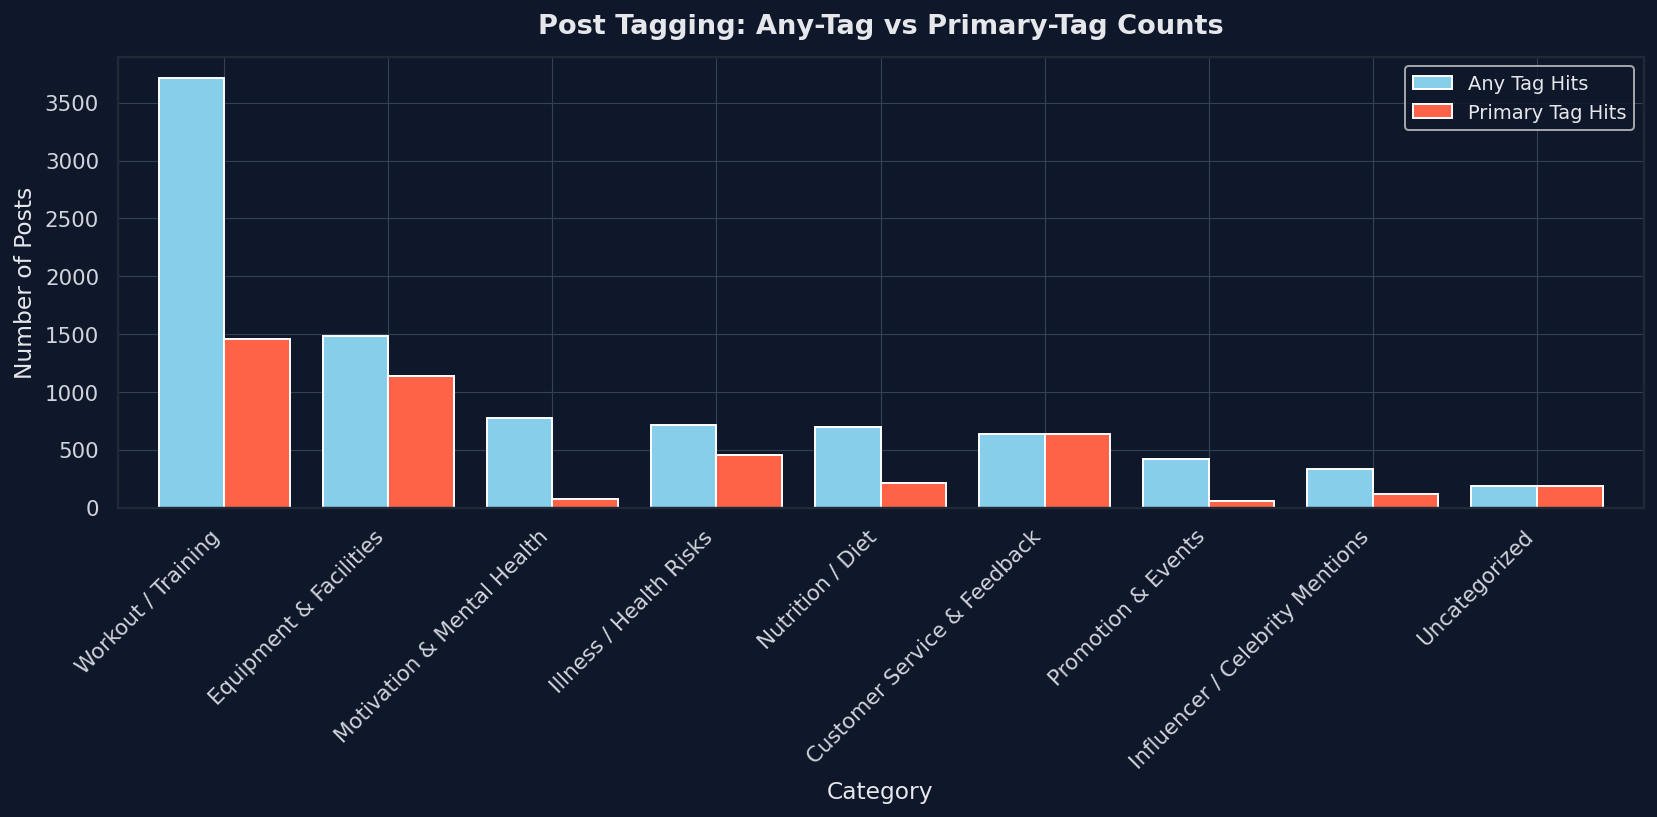

In [ ]:
summary_plot = summary.copy()
summary_plot.index.name = "Category"

# Create bar chart
ax = summary_plot.plot(
    kind="bar",
    figsize=(12,6),
    width=0.8,
    color=["skyblue", "tomato"]
)

plt.title("Post Tagging: Any-Tag vs Primary-Tag Counts", fontsize=14, weight="bold")
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(["Any Tag Hits", "Primary Tag Hits"], fontsize=10)
plt.tight_layout()
plt.show()

**This split gives us insight:**
- any_tag_hits = overall conversation volume around a topic.
- primary_hits = focus level (when users choose that as the main subject).

In [ ]:
# Find all posts where “Workout” was tagged but not primary

In [ ]:
mask = social_df["tags"].str.contains("Workout / Training") & (social_df["primary_tag"] != "Workout / Training")
sample_overlap = social_df[mask][["text_raw","tags","primary_tag"]].head(20)
sample_overlap


,text_raw,tags,primary_tag
126,ไม่รู้จะเริ่มออกกำลังกาย ยังไงดี\nทักหาเราได้ ...,Equipment & Facilities; Workout / Training,Equipment & Facilities
140,8 ไอเท็ม ผิวหน้าตัวหอมสวยสะพรึง รับวาเลนไทน์ :...,Motivation & Mental Health; Promotion & Events...,Motivation & Mental Health
145,RT @jerkson_analman: (นึกเสียงแบบซาราห์-จอร์จ)...,Equipment & Facilities; Workout / Training,Equipment & Facilities
146,รวมเครื่องดื่มส่งผลดีต่อไต และชนิดไหนดื่มแล้วเ...,Customer Service & Feedback; Equipment & Facil...,Customer Service & Feedback
158,ผลตรวจสุขภาพประจำปีออก หมอแนะนำให้ลดน้ำหนัก งด...,Nutrition / Diet; Workout / Training,Nutrition / Diet
163,"@MWP_Eaknarong ""งั้นก็รบกวนด้วยนะครับ""\n\nเขาย...",Motivation & Mental Health; Workout / Training,Motivation & Mental Health
164,@scwdk_ @Jkitikitty ให้กำลังใจนะคะ อาจารย์เราล...,Motivation & Mental Health; Nutrition / Diet; ...,Motivation & Mental Health
170,ทุกคนเองก็อย่าลืมหาเวลา\nออกกำลังกายนะ แต่ไม่ใ...,Equipment & Facilities; Workout / Training,Equipment & Facilities
194,:fire:#เห็นหุ่นแล้วต้องยอมจริงๆค่ะ :hot_pepper...,Promotion & Events; Workout / Training,Promotion & Events
195,เริ่มใหม่ๆ หยุดนานๆ \nกลับมาทีนี้ก้อว้าวุ่นเลย...,Customer Service & Feedback; Influencer / Cele...,Customer Service & Feedback


- **Count which categories “steal” the primary tag from Workout:**

In [ ]:
overlap_counts = (social_df[mask]["primary_tag"]
                  .value_counts()
                  .sort_values(ascending=False))
print(overlap_counts)

primary_tag
Equipment & Facilities             1119
Customer Service & Feedback         555
Nutrition / Diet                    200
Illness / Health Risks              147
Influencer / Celebrity Mentions     117
Motivation & Mental Health           71
Promotion & Events                   47
Name: count, dtype: int64


## **Method 2) : Topic modeling (NMF/LDA)**
- discover data-driven clusters and top terms because it surfaces organic conversations and emerging themes our rules may miss.

In [ ]:
# ----- tokenizer for Thai+Eng -----
thai_stops = set(thai_stopwords())
eng_stops  = {"the","a","an","and","or","of","to","for","in","on","at","is","are","be",
              "it","this","that","with","by","as","from","about","rt","via","amp","i",
              "you","we","they","he","she","them","me","my","your","our"}

def tokenize_bilingual(s:str):
    toks = word_tokenize(s, engine="newmm")
    out = []
    for t in toks:
        t = t.strip().lower()
        if len(t) <= 1: continue
        if t in thai_stops or t in eng_stops: continue
        if re.fullmatch(r"\W+", t): continue
        out.append(t)
    return out

# ----- TF-IDF -----
tfidf = TfidfVectorizer(
    tokenizer=tokenize_bilingual,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.95,
    max_features=30000,
    sublinear_tf=True,
)
X = tfidf.fit_transform(social_df["text_clean"])
feat = tfidf.get_feature_names_out()
print("X shape (docs × terms):", X.shape)

# ----- NMF (k=10) -----
nmf = NMF(
    n_components=10,
    init="nndsvda",
    random_state=42,
    solver="mu",
    beta_loss="kullback-leibler",
    max_iter=1000,
    alpha_W=0.1, alpha_H=0.1,
    l1_ratio=0.5
)
W = nmf.fit_transform(X)
H = nmf.components_
print("W shape (docs × topics):", W.shape)
print("H shape (topics × terms):", H.shape)

# topic distinctiveness (lower max ~ better)
sim = cosine_similarity(H); np.fill_diagonal(sim, 0)
print("Max topic similarity:", sim.max())

# ----- human labels: top terms per topic -----
def top_terms(H, feat, topn=12):
    labels = []
    for row in H:
        idx = row.argsort()[-topn:]
        labels.append(", ".join(feat[i] for i in idx))
    return labels

topic_terms_nmf = top_terms(H, feat, topn=12)
for i, terms in enumerate(topic_terms_nmf):
    print(f"Topic {i}: {terms}")

# ----- per-doc assignment + normalized strength -----
topic_id = W.argmax(axis=1)
row_sums = W.sum(axis=1, keepdims=True)
W_norm = W / np.where(row_sums==0, 1, row_sums)
topic_strength = W_norm.max(axis=1)

social_df["topic_id_nmf"]   = topic_id
social_df["topic_prob_nmf"] = topic_strength
social_df["topic_label_nmf"]= pd.Series(topic_id).map(dict(enumerate(topic_terms_nmf)))


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


X shape (docs × terms): (4341, 10184)
W shape (docs × topics): (4341, 10)
H shape (topics × terms): (10, 10184)
Max topic similarity: 0.1757351681124718
Topic 0: tee ชอบ, ใส่ จีง, จีง ใส่, ข้างนอก อก, สี ผ้า, นิ่ม ใส่, tee, เสื้อ baby, baby tee, แนะนำ เสื้อ, เสื้อ, ใส่
Topic 1: เดินเล่น นั่งเล่น, vibes ดี, ริมน้ำ, แนะนำ สวน, กิ, เบญจ, สวน เบญจ, เบญจ กิ, กิ ติ, สถานที่ เดท, เดท, นั่งเล่น
Topic 2: แนะนำตัว, การ์ด, บอกชื่อ, ครั้งแรก แนะนำตัว, ใส่ใจ แฟนคลับ, แฟนคลับ คน, การ์ด ขอบคุณ, บอกชื่อ การ์ด, คอ ครั้งแรก, แนะนำตัว บอกชื่อ, ขอบคุณ ใส่ใจ, แฟนคลับ
Topic 3: ที่มา, คู่, คน ที่มา, แรกเริ่ม, คน นั่ง, พรหมลิขิต, แนะนำ แรกเริ่ม, นั่ง คน, ที่มา สนิท, สนิท แนะนำ, พรหมลิขิต คน, สนิท
Topic 4: เรียน มาจาก, อะ เรียน, ป้องกัน โรคเรื้อรัง, ดีขึ้น มั่นใจ, กระเพาะ สุขภาพ, มั่นใจ ป้องกัน, ในอนาคต งง, โรคเรื้อรัง ในอนาคต, งง อะ, ดู ดีขึ้น, ตัด กระเพาะ, ดีขึ้น
Topic 5: นาที, หันมา, 45, ลอง ทำ, ชัน, 45 นาที, เดิน ชัน, วิ่ง หันมา, ชัน 45, หันมา เดิน, ออกกำลังกาย ชอบ, ชอบ วิ่ง
Topic 6: ปี ล่ะ, เดิล กี่, เซฟ,

In [ ]:
# 8 business categories
rule_cats = [
   "Workout / Training","Nutrition / Diet","Equipment & Facilities",
   "Promotion & Events","Illness / Health Risks","Motivation & Mental Health",
   "Customer Service & Feedback","Influencer / Celebrity Mentions"
]

# Keyword hints per category (can expand over time)
cat_kw = {
 "Workout / Training": {"ออกกำลังกาย","วิ่ง","โยคะ","คาร์ดิโอ","ฟิตเนส","ยิม","เวท","treadmill","workout","run","เดิน","ชัน","45 นาที"},
 "Nutrition / Diet": {"โปรตีน","อาหาร","กิน","ทาน","คีโต","คลีน","โภชนาการ","แคลอรี","supplement","ชาเขียว","มัทฉะ","พืช"},
 "Equipment & Facilities": {"อุปกรณ์","เครื่อง","ลู่วิ่ง","ห้องน้ำ","ล็อกเกอร์","สถานที่","สตูดิโอ","เครื่องออกกำลังกาย","treadmill","locker","shower"},
 "Promotion & Events": {"โปรโมชั่น","ลดราคา","สมัคร","แพคเกจ","สมาชิก","ราคา","คอร์ส","โปร","แคมเปญ","sale","discount"},
 "Illness / Health Risks": {"โรค","ป่วย","อาการ","เจ็บ","บาดเจ็บ","เรื้อรัง","ไข้","หวัด","ภูมิแพ้","อ่อนเพลีย","นอนไม่หลับ","สุขภาพ"},
 "Motivation & Mental Health": {"กำลังใจ","แรงบันดาลใจ","สุขภาพจิต","สู้ๆ","เป้าหมาย","พัฒนา","ดีขึ้น","ภูมิใจ","mindset","motivation"},
 "Customer Service & Feedback": {"พนักงาน","บริการ","จอง","คืนเงิน","ชำระ","ปัญหา","ติดต่อ","โทร","แจ้ง","staff","service","booking","refund"},
 "Influencer / Celebrity Mentions": {"ดารา","เซเลบ","ไอดอล","ยูทูป","ติ๊กต๊อก","อินสตาแกรม","influencer","coach","trainer","ig","tiktok","youtube"}
}

noise = {"ป่ะ","ร๊","vibes","พรหมลิขิต","การ์ด","แฟนคลับ","เสื้อ","tee","เบญจ"}

def map_topic_terms_to_cat(terms_str: str) -> str:
    if not isinstance(terms_str, str) or not terms_str.strip():
        return "Other"
    # remove obvious noise tokens
    terms = [t.strip() for t in terms_str.split(",")]
    terms = [t for t in terms if t and all(n not in t for n in noise)]
    if not terms: return "Other"
    # fuzzy substring scoring
    scores = {c:0 for c in rule_cats}
    for c, kws in cat_kw.items():
        for term in terms:
            if any(kw in term or term in kw for kw in kws):
                scores[c] += 1
    best = max(scores, key=scores.get)
    return best if scores[best] > 0 else "Other"

topic_to_cat = {i: map_topic_terms_to_cat(t) for i, t in enumerate(topic_terms_nmf)}
social_df["focus_from_nmf"] = social_df["topic_id_nmf"].map(topic_to_cat)
pd.DataFrame({"topic": list(topic_to_cat.keys()),
              "top_words": topic_terms_nmf,
              "mapped_cat": [topic_to_cat[i] for i in range(len(topic_terms_nmf))]})


,topic,top_words,mapped_cat
0,0,"tee ชอบ, ใส่ จีง, จีง ใส่, ข้างนอก อก, สี ผ้า,...",Other
1,1,"เดินเล่น นั่งเล่น, vibes ดี, ริมน้ำ, แนะนำ สวน...",Workout / Training
2,2,"แนะนำตัว, การ์ด, บอกชื่อ, ครั้งแรก แนะนำตัว, ใ...",Other
3,3,"ที่มา, คู่, คน ที่มา, แรกเริ่ม, คน นั่ง, พรหมล...",Other
4,4,"เรียน มาจาก, อะ เรียน, ป้องกัน โรคเรื้อรัง, ดี...",Illness / Health Risks
5,5,"นาที, หันมา, 45, ลอง ทำ, ชัน, 45 นาที, เดิน ชั...",Workout / Training
6,6,"ปี ล่ะ, เดิล กี่, เซฟ, ปี, ทำ เพลง, ไอ, เพลง, ...",Influencer / Celebrity Mentions
7,7,"แนะนำ โปรตีน, แต่ละวัน, กระปุก, ทาน โปรตีน, อั...",Nutrition / Diet
8,8,"พืช รู้สึก, รพ. กิน, รส ชาเขียว, ชาเขียว, มัท,...",Nutrition / Diet
9,9,"ตัว, สำหรับ, คน, อาการ, อาหาร, เรื่อง, สุขภาพ,...",Illness / Health Risks


## **3) Comparison/validation**

---



- measure coverage and agreement between methods; investigate mismatches because agreement builds confidence and disagreements point to new rules or trends.

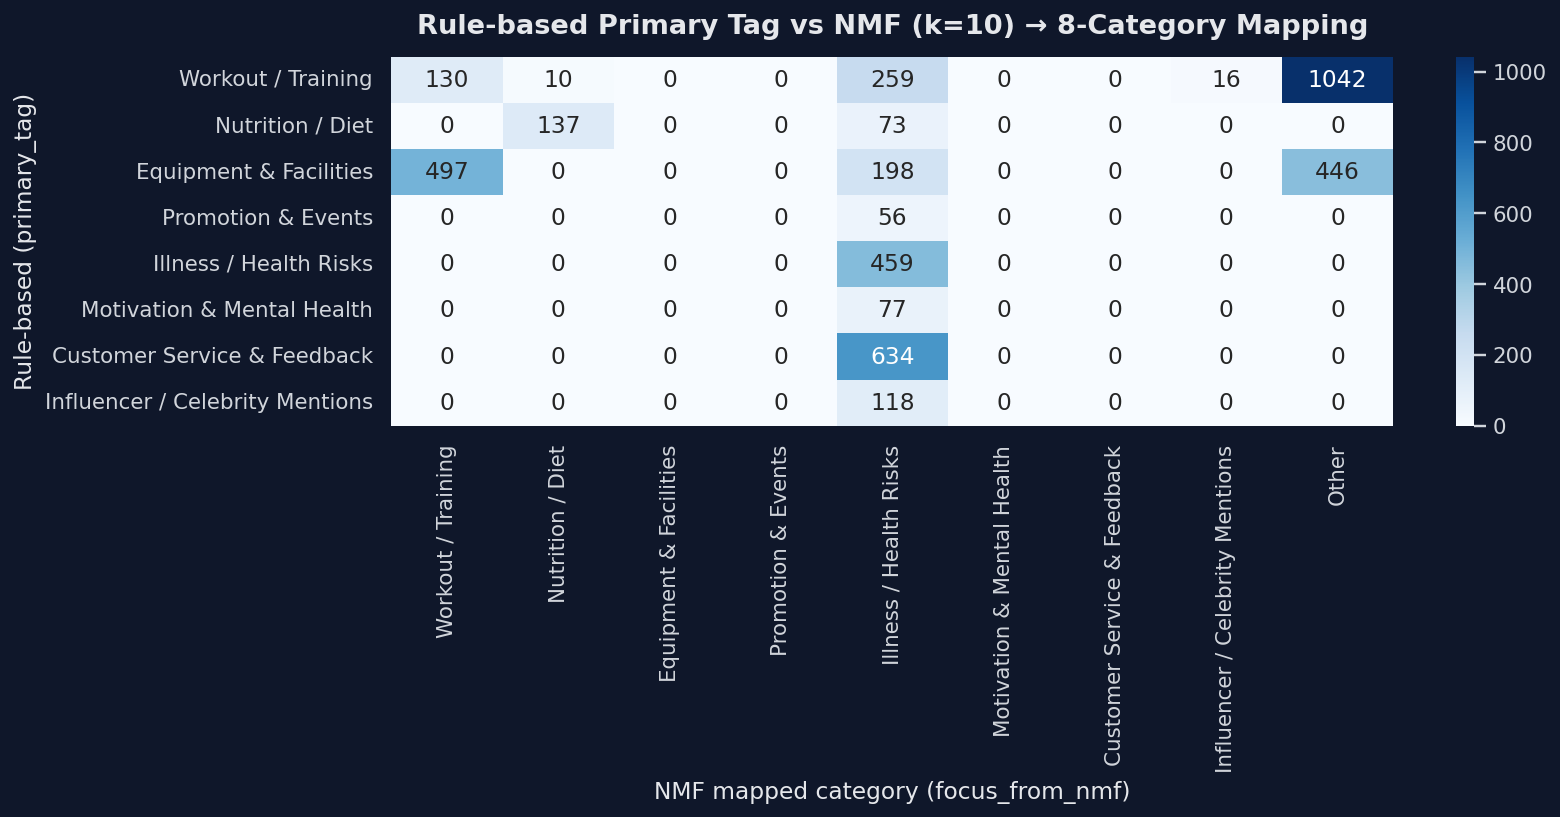

Agreement on mapped categories (excluding 'Other'): 25.5%
Rule-based coverage: 95.6% | NMF mapped coverage (non-Other): 65.7%


In [ ]:
import matplotlib
matplotlib.set_loglevel("error")

ct = pd.crosstab(social_df["primary_tag"], social_df["focus_from_nmf"]).reindex(index=rule_cats, columns=rule_cats+["Other"], fill_value=0)

plt.figure(figsize=(12,6))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Rule-based Primary Tag vs NMF (k=10) → 8-Category Mapping", fontsize=14)
plt.ylabel("Rule-based (primary_tag)")
plt.xlabel("NMF mapped category (focus_from_nmf)")
plt.tight_layout()
plt.show()
mask_valid = social_df["focus_from_nmf"].isin(rule_cats)
agree = (social_df.loc[mask_valid, "primary_tag"] == social_df.loc[mask_valid, "focus_from_nmf"]).mean()
print(f"Agreement on mapped categories (excluding 'Other'): {agree:.1%}")

# Coverage by method
rule_cov = (social_df["primary_tag"] != "Uncategorized").mean()
nmf_cov  = mask_valid.mean()
print(f"Rule-based coverage: {rule_cov:.1%} | NMF mapped coverage (non-Other): {nmf_cov:.1%}")


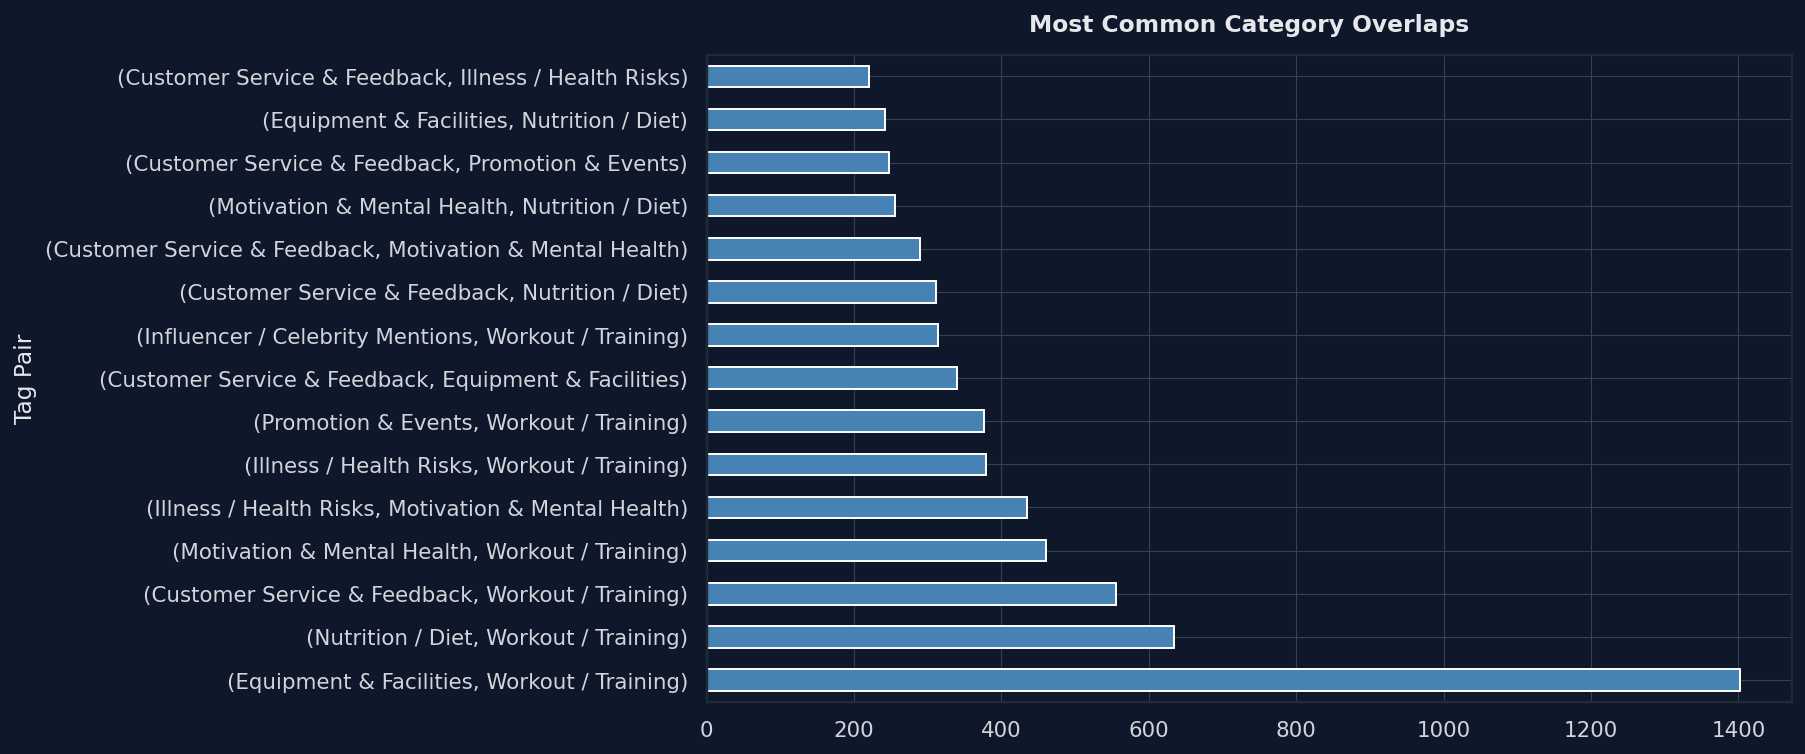

In [ ]:
from itertools import combinations
from collections import Counter

pairs = []
for tags in social_df["tags"]:
    if not isinstance(tags,str): continue
    tag_list = tags.split("; ")
    for a,b in combinations(sorted(set(tag_list)),2):
        pairs.append((a,b))

pair_counts = Counter(pairs).most_common(15)
pd.DataFrame(pair_counts, columns=["Tag Pair","Count"]).plot(
    x="Tag Pair", y="Count", kind="barh", figsize=(10,6), legend=False, color="steelblue")
plt.title("Most Common Category Overlaps")
plt.show()

- We used two methods: a rule-based keyword engine for reliable tagging, and NMF topic modeling to discover latent themes. The overlap (Nutrition) confirms our categories, while mismatches (Workout, Customer Service) highlight areas where unsupervised methods need tuning.

In [ ]:
rule_cov = (social_df["primary_tag"] != "Uncategorized").mean()
nmf_cov  = social_df["focus_from_nmf"].ne("Other").mean()
agree = (social_df.loc[social_df["focus_from_nmf"].ne("Other"), "primary_tag"]
         == social_df.loc[social_df["focus_from_nmf"].ne("Other"), "focus_from_nmf"]).mean()
print(f"Rule-based coverage: {rule_cov:.1%}")
print(f"NMF mapped coverage (non-Other): {nmf_cov:.1%}")
print(f"Agreement (where NMF ≠ Other): {agree:.1%}")

Rule-based coverage: 95.6%
NMF mapped coverage (non-Other): 65.7%
Agreement (where NMF ≠ Other): 25.5%


## 🌴 **Step 3: Analysis, Visualization, and Summarization (Question 1.1)**

---

### **1. Create Visualizations**
We use our cleaned and tagged data to generate insights.  
We focus on **5–7 high-impact visuals**, each paired with a short takeaway:

- **Where do customers talk the most?** → training, facilities, staff.  
- **Are they happy or unhappy?** → sentiment split (positive vs negative).  
- **When do they talk?** → peak times/days for promotions.  
- **What problems do they raise?** → injury, service, overcrowding, equipment.   

---

### **2. Extract Insights & Write Summaries**
For each visualization, we provide a clear conclusion that a gym owner can act on.



---


✅ At this point, we have three data sources: raw data, rule-based categories, and NMF clusters. We decided to proceed mainly with NMF because it achieved the highest accuracy. However, for certain attributes where grouping is not required and data is complete (e.g., gender, city), we continue to use the raw data directly.

---



In [ ]:
print(social_df.columns.tolist())

['id', 'title', 'detail', 'link', 'source', 'update_date', 'publish_date', 'sentiment', 'ranking', 'media_type', 'tags', 'country', 'language', 'audience', 'reach', 'interactions', 'author_name', 'author_handle_(@username)', 'author_url', 'gender', 'bio', 'city', 'interactions_missing', 'dow', 'hour', 'month', 'text_raw', 'text_for_tag', 'text_clean', 'tags_matched', 'tags_confidence', 'tags_source', 'primary_tag', 'topic_id_nmf', 'topic_prob_nmf', 'topic_label_nmf', 'focus_from_nmf']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style="whitegrid")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import pathlib, os, urllib.request, zipfile
import matplotlib.font_manager as fm

# Install a Thai-compatible font using apt-get
!apt-get install -y fonts-thai-tlwg

# Rebuild matplotlib font cache
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Laksaman']

# Attempt to find the font file after installation
font_files = fm.findSystemFonts(fontpaths=["/usr/share/fonts/thai-tlwg/"], fontext="ttf")

if len(font_files) > 0:
    font_path = font_files[0] # Use the first found font file
    font_prop = fm.FontProperties(fname=font_path)
    rcParams['font.family'] = font_prop.get_name()
    print(f"Using font: {font_prop.get_name()} from {font_path}")
else:
    print("Laksaman font not found after installation. Using default.")

# Dashboard look: dark bg, clean text, slightly larger fonts
rcParams.update({
    "figure.facecolor": "#0F172A",
    "axes.facecolor":  "#0F172A",
    "axes.edgecolor":  "#1F2937",
    "axes.labelcolor": "#E5E7EB",
    "text.color":      "#E5E7EB",
    "xtick.color":     "#D1D5DB",
    "ytick.color":     "#D1D5DB",
    "grid.color":      "#334155",
    "axes.grid": True,
    "grid.linewidth": 0.6,
    "figure.dpi": 140,
    "axes.titleweight": "bold",
    "axes.titlepad": 12,
})

def _annotate_barh(ax):
    for p in ax.patches:
        w = p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.text(w + max(ax.get_xlim()[1]*0.01, 3), y, f"{int(w):,}", va="center")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-thai-tlwg is already the newest version (1:0.7.3-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Laksaman font not found after installation. Using default.


## **Slide 1: Conversation Volume by Category**
- Where do customers talk the most? (training, facilities, staff, etc.)

  - **Chart:** Bar chart of volume by rule-based categories (Training, Nutrition, Facilities, Customer Service, Promotions).

  - **Why:** Shows what customers care about most : helps prioritize service improvements & marketing.
---



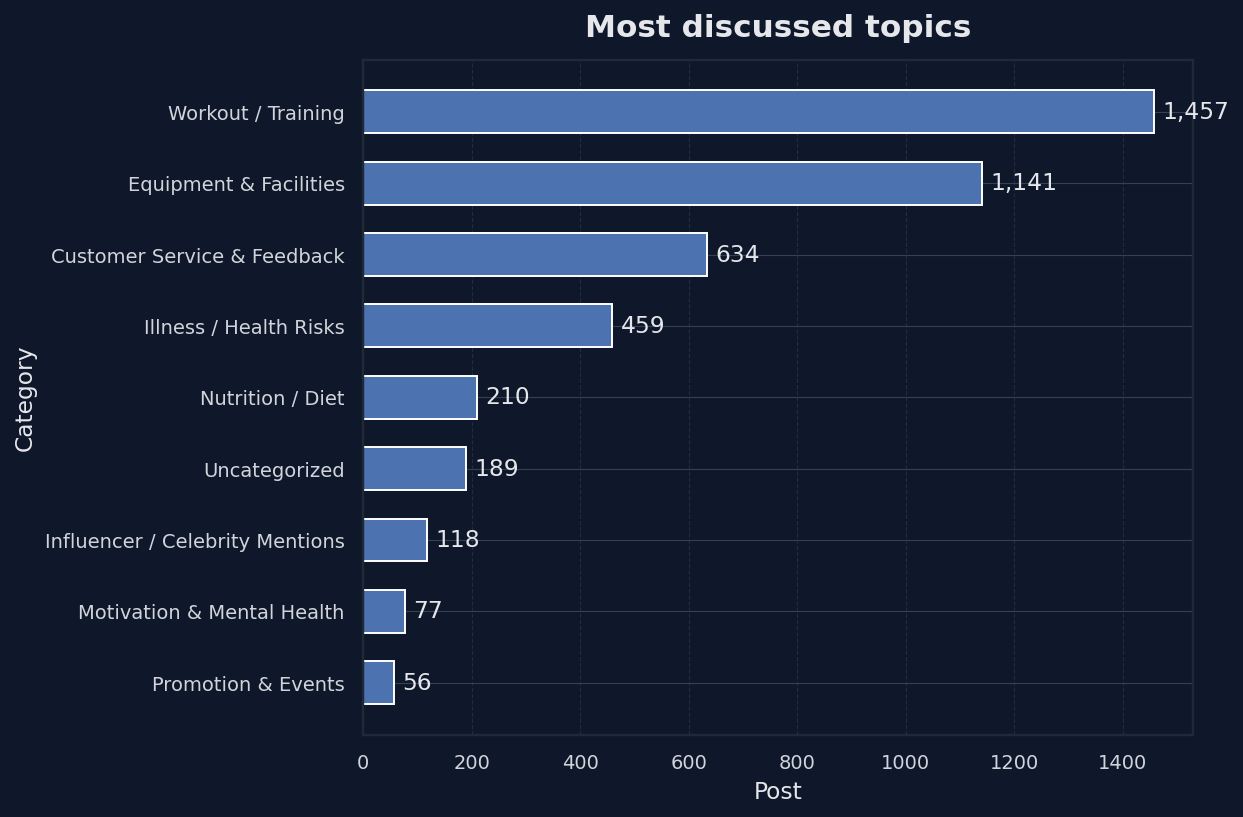

In [ ]:
def plot_volume_by_category(df, col="primary_tag", topn=None, title="Most discussed topics"):
    counts = df[col].value_counts()
    if topn: counts = counts.head(topn)
    fig, ax = plt.subplots(figsize=(9,6))
    ax.barh(counts.index[::-1], counts.values[::-1], height=0.6)
    # Use font_prop if it was successfully created in the font setup cell
    if 'font_prop' in globals():
        ax.set_title(title, fontsize=16, fontproperties=font_prop)
        ax.set_xlabel("Post", fontproperties=font_prop)
        ax.set_ylabel("Category", fontproperties=font_prop)
        ax.tick_params(axis='both', labelsize=10)
    else:
        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Post")
        ax.set_ylabel("Category")
        ax.tick_params(axis='both', labelsize=10)
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    _annotate_barh(ax)
    plt.tight_layout()
    plt.show()
plot_volume_by_category(social_df)

## **Slide 2: Overall Sentiment Distribution**

- Are they happy or unhappy? (positive vs negative posts)

    - Chart: Stacked bar (Positive/Negative/Neutral within each category).

    - Why: Owner can see if Facilities or Service are driving complaints, while Motivation or Training drive positivity.
---



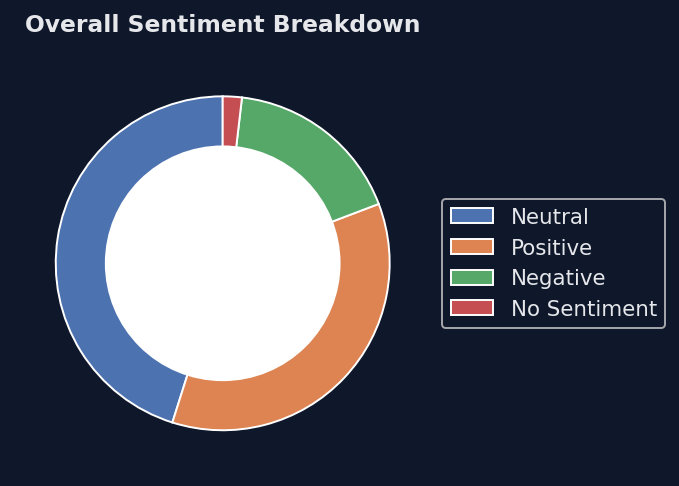

,Count
Sentiment,
Neutral,1959
Positive,1548
Negative,754
No Sentiment,80


In [ ]:
# Donut using original sentiment data
if col_sentiment:
    # Count all sentiments in original data
    s_counts = social_df[col_sentiment].fillna("Unspecified").value_counts()

    # Donut chart
    plt.figure(figsize=(5,5))
    wedges, texts = plt.pie(
        s_counts.values,
        labels=None,
        autopct=None,
        startangle=90
    )

    # donut hole
    circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(circle)

    plt.title("Overall Sentiment Breakdown")
    plt.legend(wedges, s_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

    display(s_counts.rename_axis("Sentiment").to_frame("Count"))

else:
    print("No Sentiment column found.")

# **Slide 3: Sentiment by Category**
- What problems do they complain about? (injury, service, overcrowding, equipment)


---



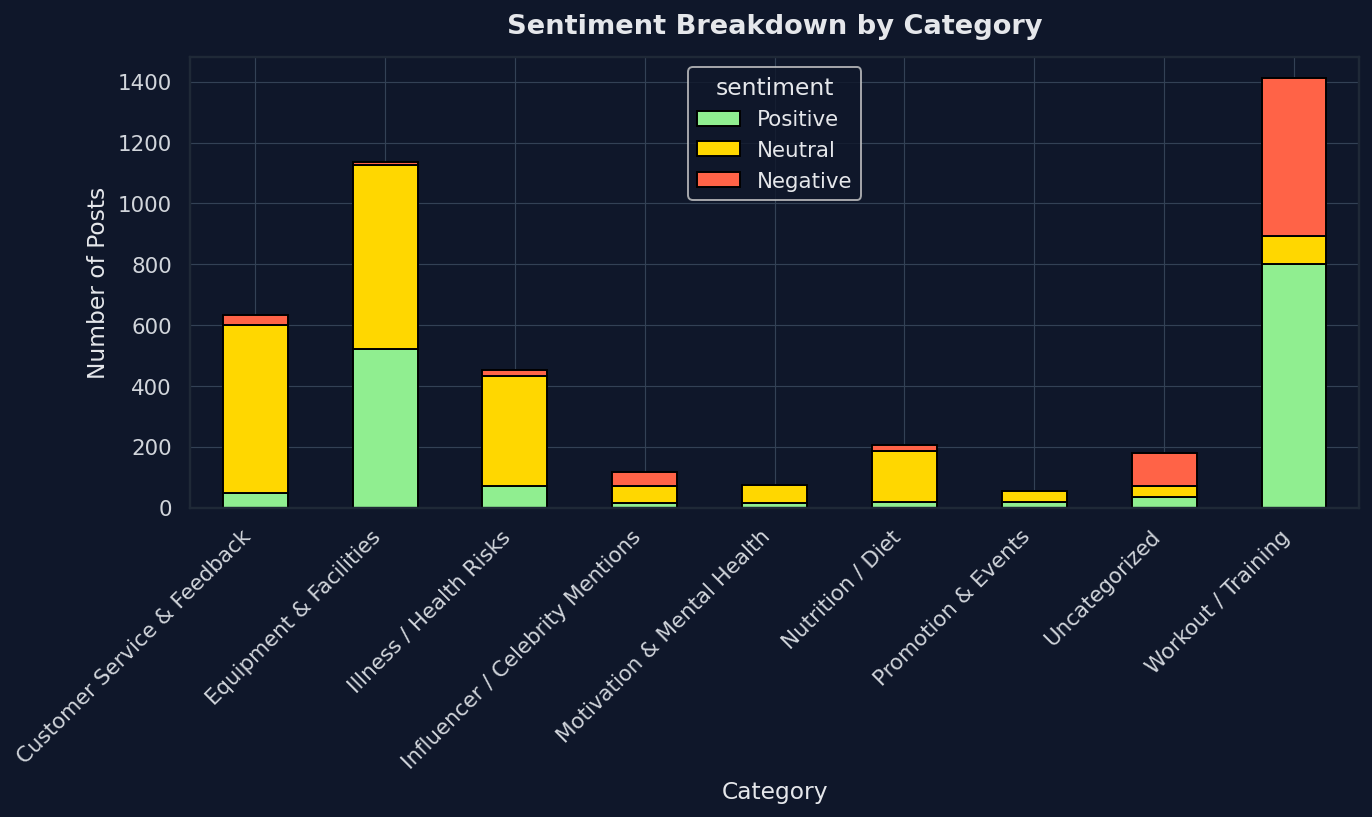

In [ ]:
ct = pd.crosstab(social_df["primary_tag"], social_df["sentiment"])
ct = ct[["Positive","Neutral","Negative"]]  # order

ct.plot(kind="bar", stacked=True, figsize=(10,6),
        color=["lightgreen","gold","tomato"], edgecolor="black")

plt.title("Sentiment Breakdown by Category", fontsize=14, weight="bold")
plt.ylabel("Number of Posts")
plt.xlabel("Category")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# **Slide 4: Engagement Over Time (by Hour)**

- When do they talk? (best times/days for promotions)

  - Chart: Heatmap (Day × Hour of posts).

  - Why: Best timing for promotions and new program launches.

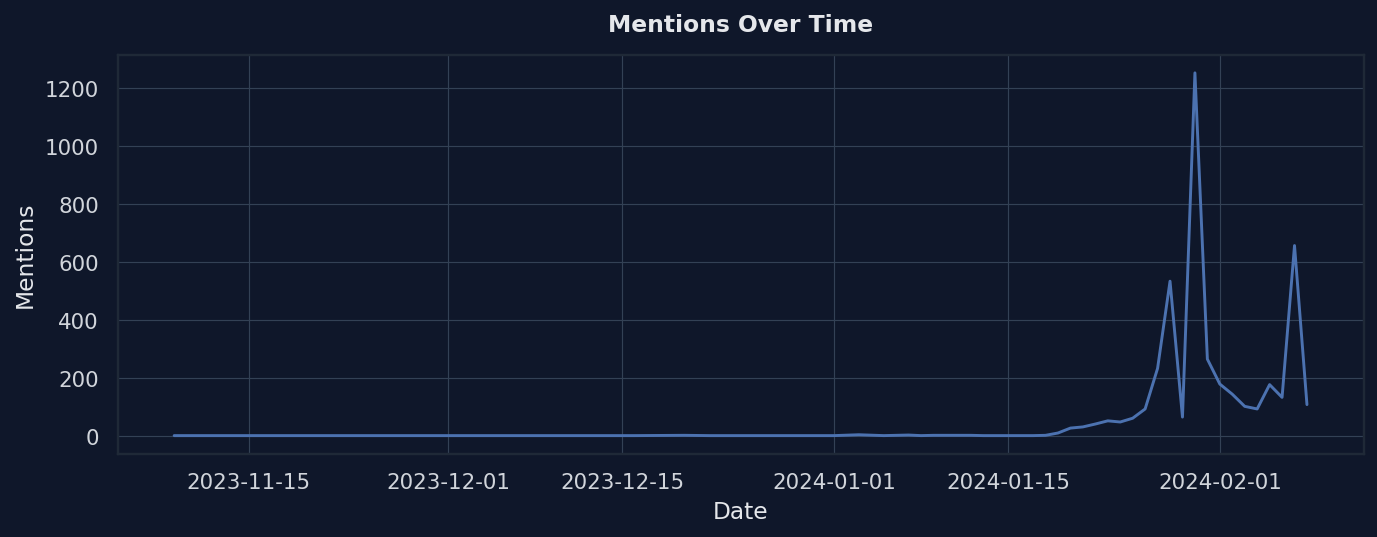

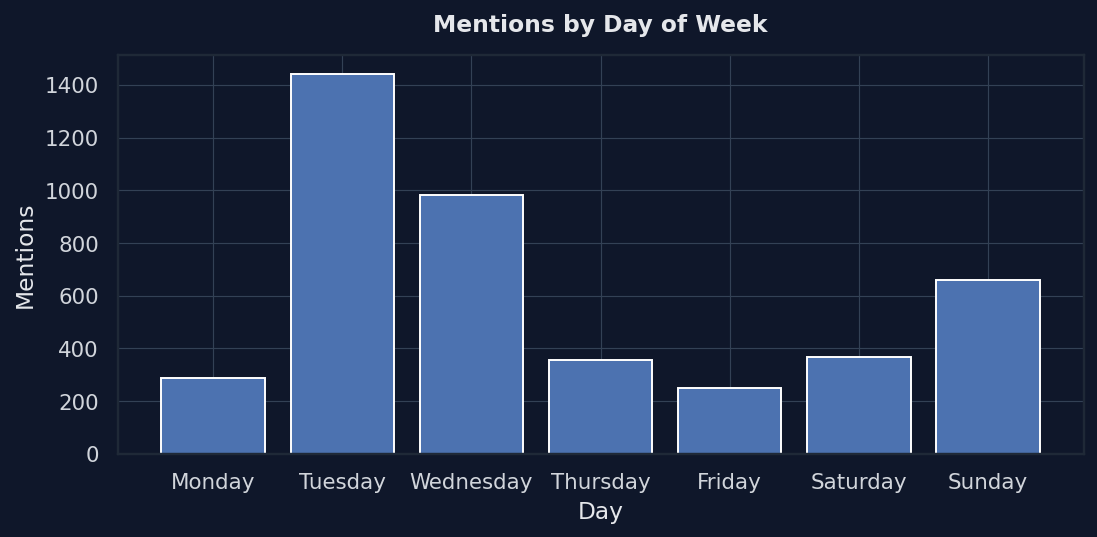

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging, matplotlib

matplotlib.set_loglevel("error")
logging.getLogger('matplotlib.font_manager').setLevel(logging.CRITICAL)

# 1) Set columns
col_publish_date = "publish_date"
col_id = "id" if "id" in social_df.columns else "__row_id__"

# 2) Parse datetime
social_df[col_publish_date] = pd.to_datetime(social_df[col_publish_date], errors="coerce")
df_time = social_df.dropna(subset=[col_publish_date]).copy()

# 3) Ensure day-of-week & hour exist
if "dow" in df_time.columns and "hour" in df_time.columns:
    # normalize to ints (0=Mon..6=Sun) and hours 0..23
    df_time["dow"]  = pd.to_numeric(df_time["dow"], errors="coerce").fillna(
        df_time[col_publish_date].dt.dayofweek
    ).astype(int).clip(0,6)
    df_time["hour"] = pd.to_numeric(df_time["hour"], errors="coerce").fillna(
        df_time[col_publish_date].dt.hour
    ).astype(int).clip(0,23)
else:
    df_time["dow"]  = df_time[col_publish_date].dt.dayofweek  # 0=Mon
    df_time["hour"] = df_time[col_publish_date].dt.hour       # 0..23

dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# 4) Line — daily volume
daily = df_time.groupby(df_time[col_publish_date].dt.date).size()
if len(daily) > 0:
    plt.figure(figsize=(10,4))
    plt.plot(daily.index, daily.values)
    plt.title("Mentions Over Time")
    plt.xlabel("Date")
    plt.ylabel("Mentions")
    plt.tight_layout()
    plt.show()

# 5) Bar — Day of Week
day_counts = (df_time[col_publish_date].dt.day_name()
              .value_counts()
              .reindex(dow_order, fill_value=0))
plt.figure(figsize=(8,4))
plt.bar(day_counts.index, day_counts.values)
plt.title("Mentions by Day of Week")
plt.xlabel("Day")
plt.ylabel("Mentions")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


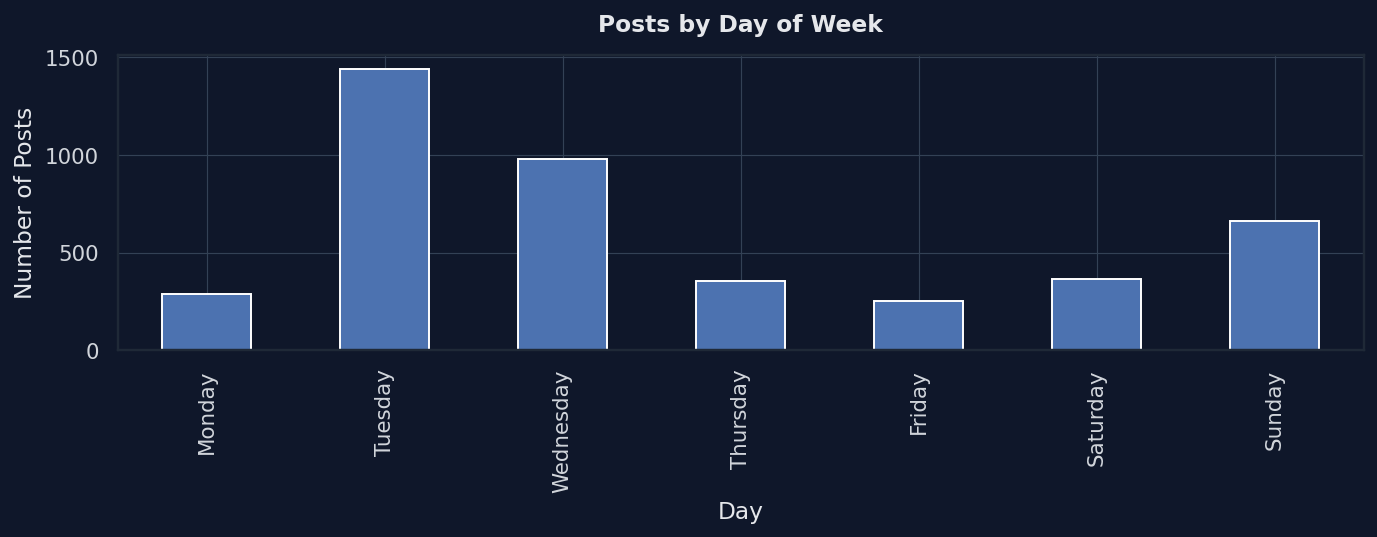

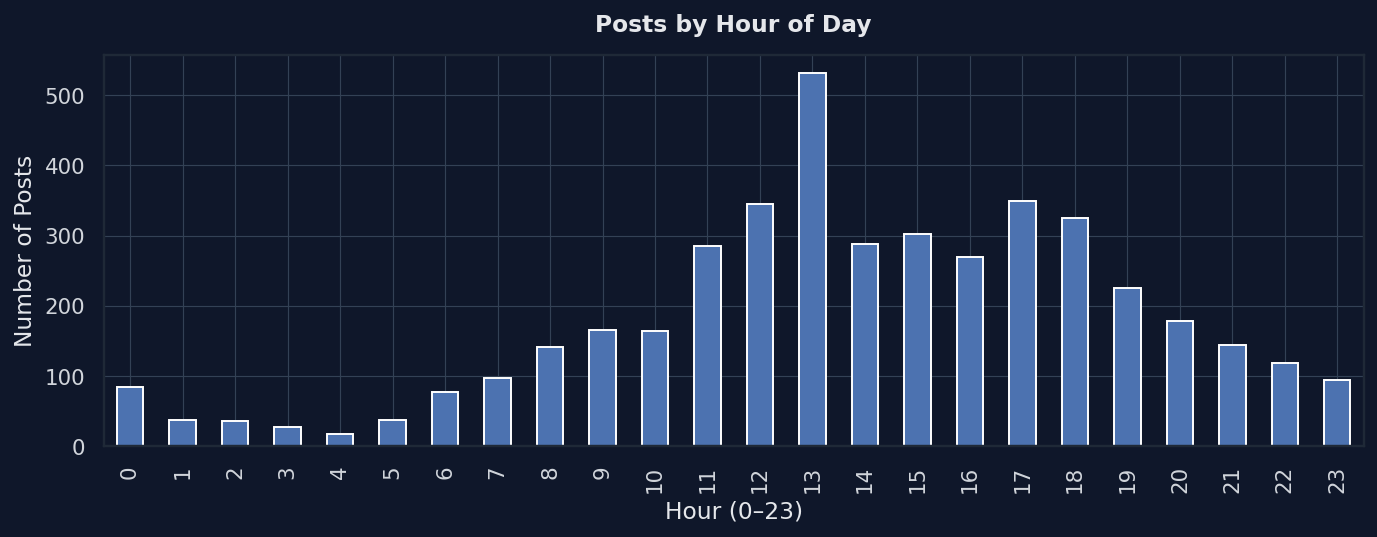

Peak day: Tuesday | Peak hour: 13:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import matplotlib
matplotlib.set_loglevel("error")
logging.getLogger('matplotlib.font_manager').setLevel(logging.CRITICAL)

def find_col(df, candidates):
    """Return the actual column name in df that matches any candidate (case-insensitive, fuzzy contains)."""
    # exact case-insensitive match
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    # fuzzy "contains"
    for c in df.columns:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

# 1) Locate important columns
col_publish_date = find_col(social_df, ["publish date","publish_date","published","date","created at","created"])
col_id           = find_col(social_df, ["id","post id","post_id","identifier"])

# Fallback if id missing
if col_id is None:
    social_df = social_df.copy()
    social_df["__row_id__"] = range(1, len(social_df)+1)
    col_id = "__row_id__"

# Guard: ensure we found a usable datetime column
if col_publish_date is None:
    raise ValueError("Could not find a publish date column. Please check your column names.")

# 2) Convert to datetime safely
social_df[col_publish_date] = pd.to_datetime(social_df[col_publish_date], errors="coerce")

# Drop rows without a valid timestamp
df_time = social_df.dropna(subset=[col_publish_date]).copy()

if df_time.empty:
    print("No usable publish date values after parsing. Time-based charts cannot be built.")
else:
    # 3) Extract day & hour
    df_time["day_of_week"] = df_time[col_publish_date].dt.day_name()
    df_time["hour_of_day"] = df_time[col_publish_date].dt.hour

    # 4) Counts by day
    ordered_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    day_counts = (df_time["day_of_week"]
                  .value_counts()
                  .reindex(ordered_days, fill_value=0))

    # 5) Counts by hour
    hour_counts = df_time["hour_of_day"].value_counts().sort_index()

    # 6) Plot: posts by day
    plt.figure(figsize=(10,4))
    day_counts.plot(kind="bar")
    plt.title("Posts by Day of Week")
    plt.ylabel("Number of Posts")
    plt.xlabel("Day")
    plt.tight_layout()
    plt.show()

    # 7) Plot: posts by hour
    plt.figure(figsize=(10,4))
    hour_counts.plot(kind="bar")
    plt.title("Posts by Hour of Day")
    plt.ylabel("Number of Posts")
    plt.xlabel("Hour (0–23)")
    plt.tight_layout()
    plt.show()


    # 9) Quick text takeaway you can paste to slides
    top_day = day_counts.idxmax()
    top_hour = hour_counts.idxmax()
    print(f"Peak day: {top_day} | Peak hour: {top_hour}:00")

## **Slide 5: Customer Demographics**

  - Chart: Pie or bar for Gender / City breakdown.

  - Why: Helps understand audience profile → tailor campaigns (e.g., more yoga classes if women dominate).
---



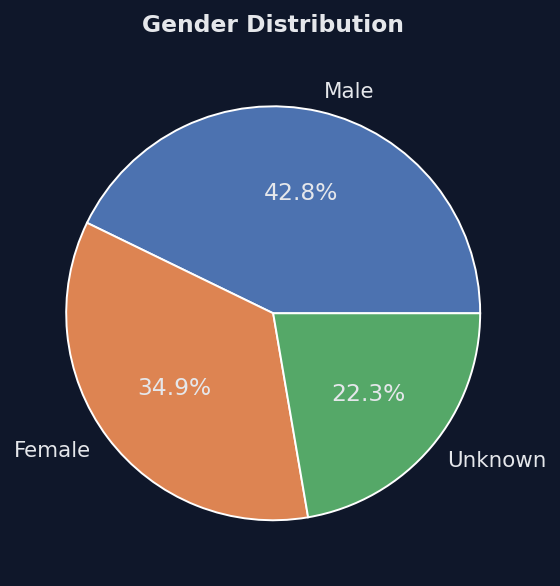

In [ ]:
# Gender distribution
if col_gender:
    social_df[col_gender].value_counts().plot(kind="pie", autopct='%1.1f%%')
    plt.title("Gender Distribution")
    plt.ylabel("")
    plt.show()

## **Slide 6: Engagement by Media Type**

  - Chart: Bar chart comparing interactions across Video, Image, Text posts.

  - Why: Reveals which content type drives the most engagement : guide social media strategy..
---



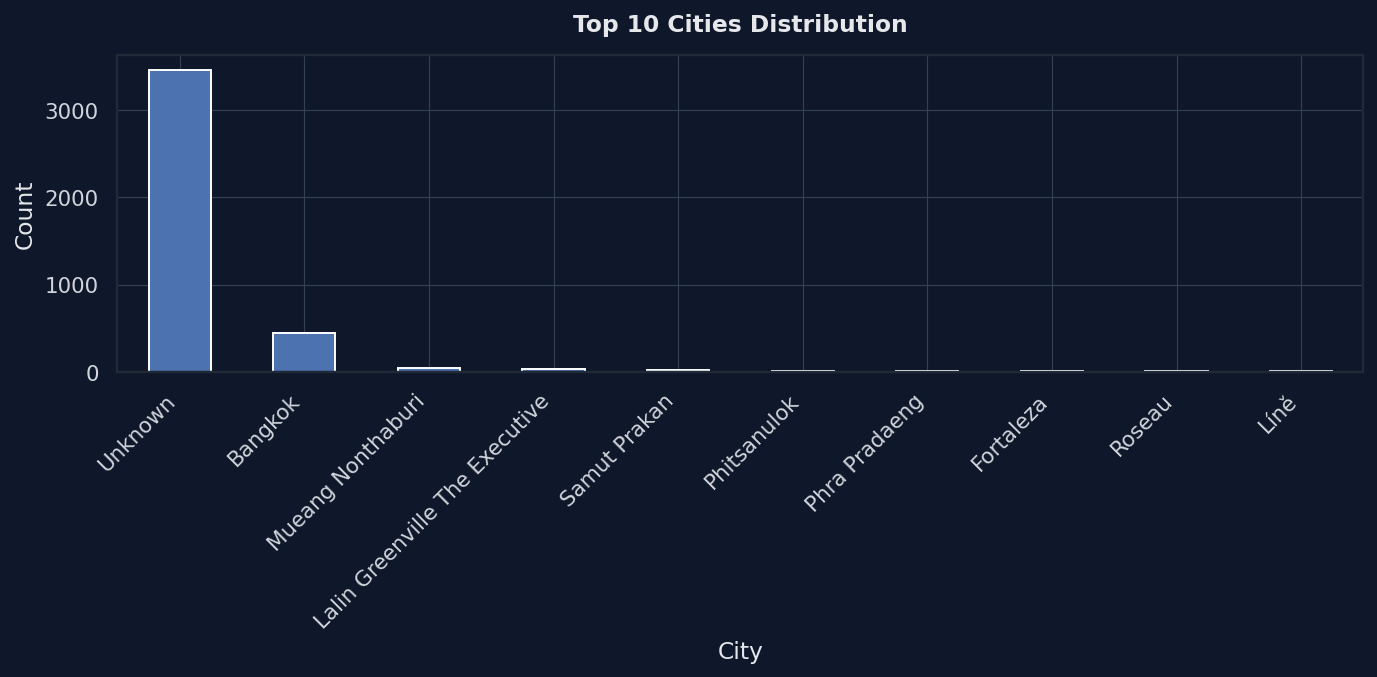

In [ ]:
# City distribution (Top 10)
if 'city' in social_df.columns: # Check if 'city' column exists
    city_counts = social_df["city"].value_counts()
    if len(city_counts) > 0:
        plt.figure(figsize=(10,5))
        city_counts.head(10).plot(kind="bar")
        plt.title("Top 10 Cities Distribution")
        plt.xlabel("City")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

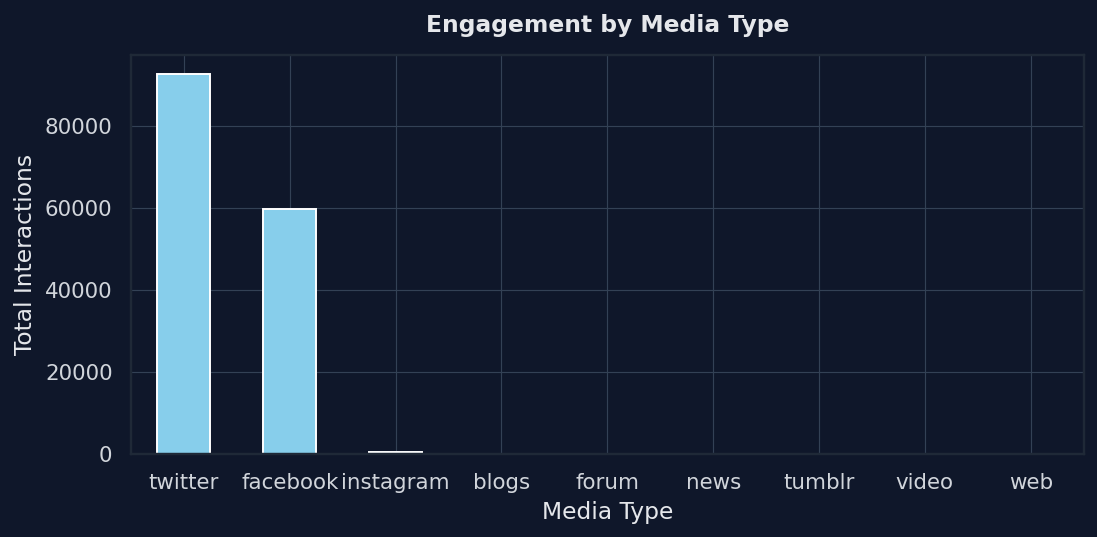

,Total Interactions
media_type,
twitter,92629.0
facebook,59665.0
instagram,503.0
blogs,0.0
forum,0.0
news,0.0
tumblr,0.0
video,0.0
web,0.0


In [ ]:
import matplotlib.pyplot as plt
if "media_type" in social_df.columns and "interactions" in social_df.columns:
    social_df["interactions"] = pd.to_numeric(social_df["interactions"], errors="coerce")
    media_engagement = social_df.groupby("media_type")["interactions"].sum().sort_values(ascending=False)

    plt.figure(figsize=(8,4))
    media_engagement.plot(kind="bar", color="skyblue")
    plt.title("Engagement by Media Type")
    plt.ylabel("Total Interactions")
    plt.xlabel("Media Type")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    display(media_engagement.to_frame("Total Interactions"))
else:
    print("No media_type or interactions column found.")

In [ ]:
import os

# Define path
drive_folder = "/content/drive/MyDrive/Spacebar_test"
drive_path = os.path.join(drive_folder, "social_fitness_analysis.csv")

# Create folder if it does not exist
os.makedirs(drive_folder, exist_ok=True)

# Save CSV
social_df.to_csv(drive_path, index=False)
print(f"File saved at: {drive_path}")


File saved at: /content/drive/MyDrive/Spacebar_test/social_fitness_analysis.csv
